In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# TIF Regions
df = pd.read_csv(r'/work/Cross_percent.csv')

trim_number = 20
df_vals = pd.read_csv(r'/work/Cross_values.csv')
df = df[df_vals.sum(axis=1, numeric_only=True) >= trim_number]
df_raw = df.loc[:, df.columns != 'TIF_Name']

# Non-TIF Regions
df_nonTIF = pd.read_csv(r'/work/Community_cross_percent.csv')

df_vals_nonTIF = pd.read_csv(r'/work/Community_cross.csv')
df_nonTIF = df_nonTIF[df_vals_nonTIF.sum(axis=1, numeric_only=True) >= trim_number]
df_raw_nonTIF = df_nonTIF.loc[:, df_nonTIF.columns != 'Com_Name']

union_df = pd.concat([df_raw.iloc[:-1], df_raw_nonTIF])


pca = PCA(n_components=14)

components = pca.fit_transform(union_df) # This does all the math

### Figures
fig = px.scatter(components, 
                x=0, 
                y=1, 
                hover_name= list(df.iloc[:-1]['TIF_Name']) + list(df_nonTIF['Com_Name']),
                color=(['TIF']*df.iloc[:-1].shape[0] + ['Non-TIF']*df_nonTIF.shape[0]))
fig.show()

fig = px.scatter_3d(components, x=0, y=1, z=2, labels={'0': 'PC 0', '1': 'PC 1', '2': 'PC 2'}, hover_name= list(df.iloc[:-1]['TIF_Name']) + list(df_nonTIF['Com_Name']), color=(['TIF']*df.iloc[:-1].shape[0] + ['Non-TIF']*df_nonTIF.shape[0]))
fig.update_traces(marker_size= 3)
fig.show()


Variance Explained by PC 0 and 1 =  0.780242227372013
Variance Explained by PC 0, 1, and 2 =  0.8551121710047321


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Accommodation'),
  Text(1, 0, 'Business'),
  Text(2, 0, 'Electronic'),
  Text(3, 0, 'Entertainment'),
  Text(4, 0, 'Food'),
  Text(5, 0, 'Liquor'),
  Text(6, 0, 'Medical'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Permits'),
  Text(9, 0, 'Personal Services'),
  Text(10, 0, 'Retail'),
  Text(11, 0, 'Special'),
  Text(12, 0, 'Tabacco'),
  Text(13, 0, 'Vehicles')])

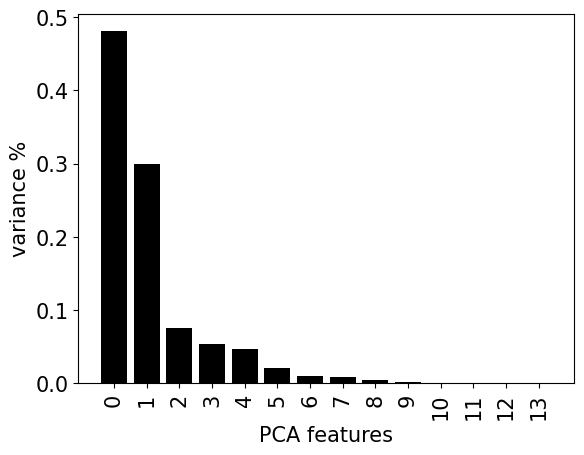

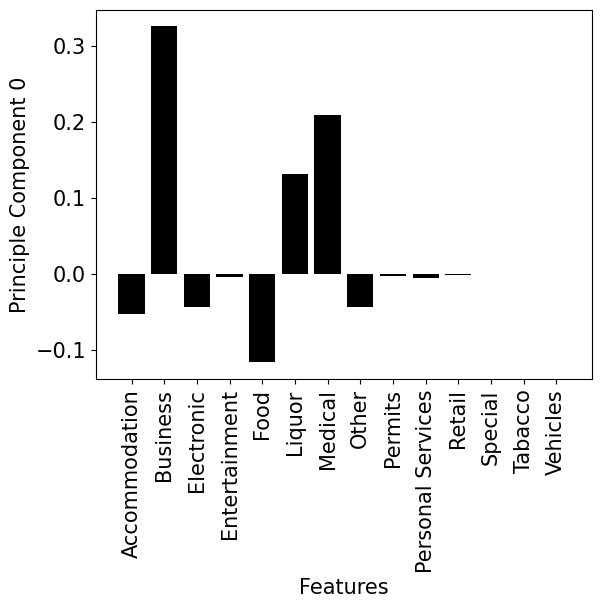

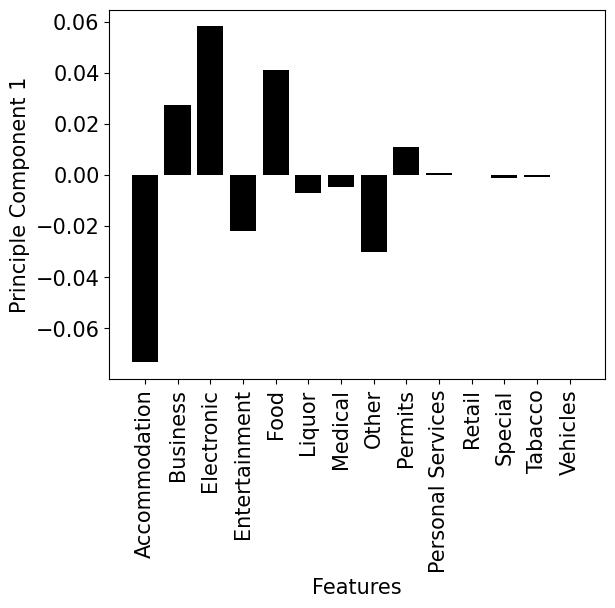

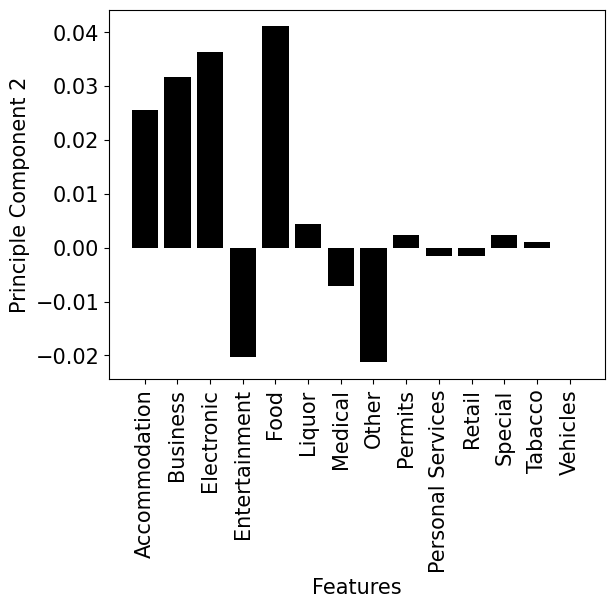

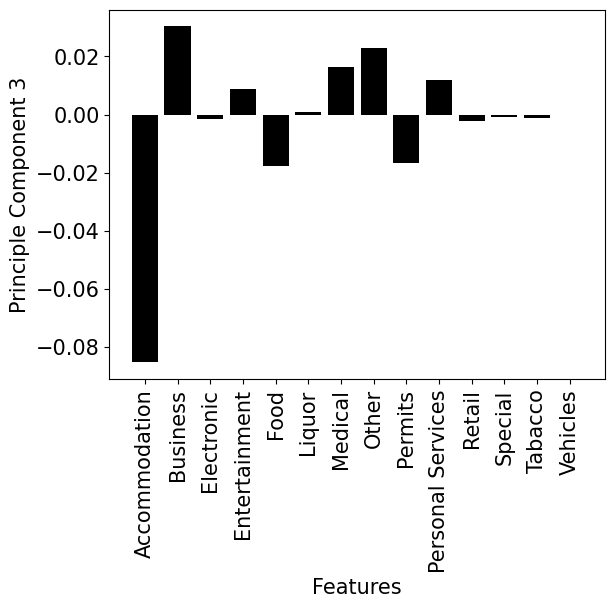

In [ ]:
# Plot the explained variances
features = range(df_raw.shape[1])
plt.figure(1)
plt.rcParams['font.size'] = 15
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features, rotation='vertical')

print("Variance Explained by PC 0 and 1 = ", sum(pca.explained_variance_ratio_[0:2]))
print("Variance Explained by PC 0, 1, and 2 = ", sum(pca.explained_variance_ratio_[0:3]))

# Component 0 Features
plt.figure(2)
plt.bar(df.columns[1:], components[0],color='black')
plt.xlabel('Features')
plt.ylabel('Principle Component 0')
plt.xticks(rotation=90)

# Component 1 Features
plt.figure(3)
plt.bar(df.columns[1:], components[1],color='black')
plt.xlabel('Features')
plt.ylabel('Principle Component 1')
plt.xticks(rotation=90)

# Component 2 Features
plt.figure(4)
plt.bar(df.columns[1:], components[2],color='black')
plt.xlabel('Features')
plt.ylabel('Principle Component 2')
plt.xticks(rotation=90)

# Component n Features
n = 3
plt.figure(5)
plt.bar(df.columns[1:], components[n],color='black')
plt.xlabel('Features')
plt.ylabel(f"Principle Component {n}")
plt.xticks(rotation=90)

In [ ]:
# Difference of means confidence 95% interval between TIF and Non-TIF on means of PC k value
import scipy as sp
import numpy as np
import math

def Extract(lst, k: int):
    return [item[k] for item in lst]

k = 2
components_TIF = components[:df.iloc[:-1].shape[0]]
components_non_TIF = components[-1*df_nonTIF.shape[0]:]
n_TIF = len(components_TIF)
n_non_TIF = len(components_non_TIF)

mean_TIF = np.mean(Extract(components_TIF, k))
mean_non_TIF = np.mean(Extract(components_non_TIF, k))
std_dev_TIF = np.std(Extract(components_TIF, k))
std_dev_non_TIF = np.std(Extract(components_non_TIF, k))
std_dev_pooled = math.sqrt(((n_TIF - 1)*(std_dev_TIF**2) + (n_non_TIF - 1)*(std_dev_non_TIF**2)) / (n_non_TIF + n_TIF - 2))

lower = (mean_TIF - mean_non_TIF) - 1.96*std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF))
upper = (mean_TIF - mean_non_TIF) + 1.96*std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF))


print("Differecne of means: ", mean_TIF - mean_non_TIF)
print(f"Difference of means 95% confidence interval for PC {k}: ", f"[{lower}, {upper}]")

z_score = (mean_TIF - mean_non_TIF)/(std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF)))
print("z score: ", z_score)
p_value = 1 - sp.stats.norm.sf(abs(z_score))
print("p value: ", p_value)

Differecne of means:  0.027094702039751124
Difference of means 95% confidence interval for PC 2:  [0.01298116448016059, 0.04120823959934166]
z score:  3.762743094967391
p value:  0.9999159700911298


In [ ]:
# Difference of means confidence 95% interval between TIF and Non-TIF on means by collumn
import scipy as sp
import numpy as np
import math

lower_bounds = [None]*df.columns[1:].shape[0]
upper_bounds = [None]*df.columns[1:].shape[0]
p_value_list = [None]*df.columns[1:].shape[0]
diff_means = [None]*df.columns[1:].shape[0]

count = 0
for col_name in df.columns[1:]:
    
    col_TIF = df.iloc[:-1][col_name].tolist()
    col_non_TIF = df_nonTIF[col_name].tolist()
    n_TIF = len(col_TIF)
    n_non_TIF = len(col_non_TIF)

    mean_TIF = np.mean(col_TIF)
    mean_non_TIF = np.mean(col_non_TIF)
    std_dev_TIF = np.std(col_TIF)
    std_dev_non_TIF = np.std(col_non_TIF)
    std_dev_pooled = math.sqrt(((n_TIF - 1)*(std_dev_TIF**2) + (n_non_TIF - 1)*(std_dev_non_TIF**2)) / (n_non_TIF + n_TIF - 2))

    lower = (mean_TIF - mean_non_TIF) - 1.96*std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF))
    upper = (mean_TIF - mean_non_TIF) + 1.96*std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF))

    z_score = (mean_TIF - mean_non_TIF)/(std_dev_pooled*math.sqrt((1/n_TIF) + (1/n_non_TIF)))
    p_value = 1 - sp.stats.norm.sf(abs(z_score))
    
    lower_bounds[count] = round(lower, 4)
    upper_bounds[count] = round(upper, 4)
    p_value_list[count] = p_value
    diff_means[count] = mean_TIF - mean_non_TIF
    count += 1

stats_df = pd.DataFrame([list(a) for a in zip(diff_means, zip(lower_bounds, upper_bounds), p_value_list)], df.columns[1:])
stats_df.to_csv(r'/work/Stats_Referece.csv')
print(stats_df.sort_values(by=0))

                          0                   1         2
Special           -0.101062  (-0.1274, -0.0747)  1.000000
Personal Services -0.005724  (-0.0076, -0.0038)  1.000000
Entertainment     -0.003169    (-0.007, 0.0007)  0.946516
Retail            -0.000033    (-0.0051, 0.005)  0.505068
Medical           -0.000009   (-0.0007, 0.0007)  0.509322
Accommodation      0.000155    (-0.0007, 0.001)  0.641492
Electronic         0.000262    (-0.0005, 0.001)  0.758435
Other              0.001243   (-0.0041, 0.0066)  0.675092
Liquor             0.003660   (-0.0082, 0.0155)  0.727889
Tabacco            0.004140   (-0.0054, 0.0137)  0.801526
Permits            0.008081    (-0.005, 0.0211)  0.887300
Vehicles           0.012297    (0.0026, 0.0219)  0.993759
Food               0.017501   (-0.0036, 0.0386)  0.948303
Business           0.062658    (0.0334, 0.0919)  0.999987


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=41bd1eeb-8ade-41a5-ae81-cf4a88f38197' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>